In [1]:
!pip install -U tensorboard
!pip install -U tensorflow-addons

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np

from tqdm import tqdm
from IPython import display

import os
import time
import pathlib

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Preprocessing

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
training_dataset_path = '/gdrive/MyDrive/dataset_project/train/'
testing_dataset_path = '/gdrive/MyDrive/dataset_project/test/'

def load_image_filenames(dataset_path):
  sketch_dataset_dir = pathlib.Path(dataset_path + 'sketch/')
  photo_dataset_dir = pathlib.Path(dataset_path + 'photo/')

  sketch_filenames = find_images(sketch_dataset_dir)
  photo_filenames = find_images(photo_dataset_dir)
  sketches_count = len(sketch_filenames)
  photos_count = len(photo_filenames)
  print(f'Sketch dataset image count: {sketches_count}, photo dataset image count: {photos_count}')
  return (sketch_filenames, photo_filenames)

def find_images(dataset_directory):
  #image_filenames = list(dataset_directory.glob('**/*.jpg'))
  #return [image_path.name for image_path in image_filenames]
  image_filenames = []
  for image_filetype in ['.jpg', '.JPG']:
    image_filenames += list(dataset_directory.glob('**/*' + image_filetype))
  image_filenames.sort()
  return image_filenames

training_sketch_filenames, training_photo_filenames = load_image_filenames(training_dataset_path)
testing_sketch_filenames, testing_photo_filenames = load_image_filenames(testing_dataset_path)
#for sketch_filename, photo_filename in zip(testing_sketch_filenames, testing_photo_filenames):
#  print(f'{sketch_filename} -- {photo_filename}')

Sketch dataset image count: 88, photo dataset image count: 88
Sketch dataset image count: 100, photo dataset image count: 100


In [5]:
from sklearn.model_selection import train_test_split

validation_split = 0.3
random_seed = 118131231

training_indices = list(range(len(training_sketch_filenames)))
partial_training_indices, validation_indices = train_test_split(
    training_indices,
    random_state=random_seed,
    train_size=(1 - validation_split)
)

partial_training_sketch_filenames = [training_sketch_filenames[index] for index in partial_training_indices]
partial_training_photo_filenames = [training_photo_filenames[index] for index in partial_training_indices]
validation_sketch_filenames = [training_sketch_filenames[index] for index in validation_indices]
validation_photo_filenames = [training_photo_filenames[index] for index in validation_indices]

print(f'partial training sketch dataset length: {len(partial_training_sketch_filenames)}, partial training photo dataset length: {len(partial_training_photo_filenames)}')
print(f'validation sketch dataset length: {len(validation_sketch_filenames)}, validation photo dataset length: {len(validation_photo_filenames)}')

partial training sketch dataset length: 61, partial training photo dataset length: 61
validation sketch dataset length: 27, validation photo dataset length: 27


In [6]:
image_width = 200
image_height = 250

def load_image_dataset(sketch_file_paths, photo_file_paths):
  sketches = load_images_from_filenames(sketch_file_paths)
  rgb_sketches = []
  for sketch in sketches:
    if sketch.shape[2] == 1:
      sketch = tf.image.grayscale_to_rgb(sketch)
    rgb_sketches.append(sketch)
  photos = load_images_from_filenames(photo_file_paths)
  return (rgb_sketches, photos)

def load_images_from_filenames(file_paths):
  images = [tf.image.decode_jpeg(tf.io.read_file(str(path.absolute()))) for path in file_paths]
  images = [tf.cast(image, tf.float32) for image in images]
  return images

partial_training_sketches, partial_training_photos = load_image_dataset(partial_training_sketch_filenames, partial_training_photo_filenames)
validation_sketches, validation_photos = load_image_dataset(validation_sketch_filenames, validation_photo_filenames)
testing_sketches, testing_photos = load_image_dataset(testing_sketch_filenames, testing_photo_filenames)

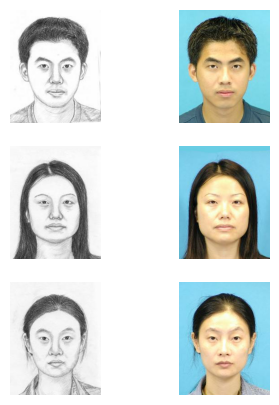

In [7]:
import matplotlib.pyplot as pyplot

pyplot.figure(figsize=(4, 5))
for index in range(1, 7, 2):
  pyplot.subplot(3, 2, index)
  pyplot.imshow(partial_training_sketches[index] / 255.0)
  pyplot.axis('off')
  pyplot.subplot(3, 2, index + 1)
  pyplot.imshow(partial_training_photos[index] / 255.0)
  pyplot.axis('off')

In [8]:
def resize(sketch, photo, width, height):
  resize_method = tf.image.ResizeMethod.BILINEAR
  sketch = tf.image.resize(
    sketch, [height, width],
    method=resize_method
  )
  photo = tf.image.resize(
    photo, [height, width],
    method=resize_method
  )
  return (sketch, photo)

def random_crop(sketch, photo, width=256, height=256):
  stacked_image = tf.stack([sketch, photo], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image,
      size=[2, height, width, 3]
  )

  return cropped_image[0], cropped_image[1]

def random_mirroring(sketch, photo):
  if tf.random.uniform(()) > 0.5:
    sketch = tf.image.flip_left_right(sketch)
    photo = tf.image.flip_left_right(photo)

  return sketch, photo

In [9]:
def random_rotation(sketch, photo):
  rotation_degrees = tf.random.normal((), 0, tf.constant(np.pi/32))
  sketch = tfa.image.rotate(sketch, rotation_degrees)
  photo = tfa.image.rotate(photo, rotation_degrees)
  return sketch, photo

In [10]:
def augment_sketches_and_photos(sketches, photos, augmentation_factor = 10):
  augmented_sketches = sketches[:]
  augmented_photos = photos[:]

  for sketch, photo in zip(sketches, photos):
    for _ in range(augmentation_factor):
      sketch, photo = random_mirroring(sketch, photo)
      sketch, photo = resize(sketch, photo, width=image_width+5, height=image_height+7)
      sketch, photo = random_crop(sketch, photo, width=image_width, height=image_height)
      sketch, photo = random_rotation(sketch, photo)
      augmented_sketches.append(sketch)
      augmented_photos.append(photo)

  return augmented_sketches, augmented_photos

In [11]:
def normalise(sketch, photo):
  return (
    normalise_single_image(sketch),
    normalise_single_image(photo)
  )

def normalise_single_image(image):
  return (image / 127.5) - 1

In [12]:
@tf.function()
def random_jitter(sketch, photo):
  sketch, photo = resize(sketch, photo, width=256, height=256)
  return sketch, photo

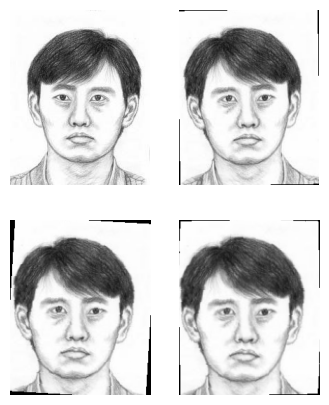

In [13]:
pyplot.figure(figsize=(4, 5))
augmented_sketches, _ = augment_sketches_and_photos(partial_training_sketches[:1], partial_training_photos[:1])
for index in range(4):
  pyplot.subplot(2, 2, index + 1)
  pyplot.imshow(augmented_sketches[index] / 255.0)
  pyplot.axis('off')
pyplot.show()

In [14]:
def preprocess_image_pair_for_training(sketch, photo):
  sketch, photo = random_jitter(sketch, photo)
  sketch, photo = normalise(sketch, photo)
  return sketch, photo

In [15]:
BUFFER_SIZE = 400
BATCH_SIZE = 1

In [16]:
augmented_partial_training_sketches, augmented_partial_training_photos = augment_sketches_and_photos(partial_training_sketches, partial_training_photos)
print(f'partial training sketch dataset length: {len(augmented_partial_training_sketches)}, partial training photo dataset length: {len(augmented_partial_training_photos)}')

partial training sketch dataset length: 671, partial training photo dataset length: 671


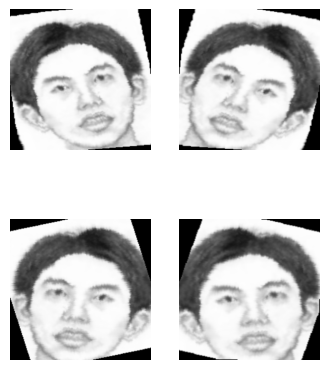

In [17]:
pyplot.figure(figsize=(4, 5))
for index in range(len(augmented_partial_training_sketches) - 4, len(augmented_partial_training_sketches)):
  input_image, _ = random_jitter(augmented_partial_training_sketches[index], augmented_partial_training_photos[index])
  pyplot.subplot(2, 2, index - len(augmented_partial_training_sketches) + 4 + 1)
  pyplot.imshow(input_image / 255.0)
  pyplot.axis('off')
pyplot.show()

In [18]:
partial_training_dataset = tf.data.Dataset.from_tensor_slices((
  augmented_partial_training_sketches,
  augmented_partial_training_photos
))
print(partial_training_dataset.take(1))
partial_training_dataset = partial_training_dataset.map(
  preprocess_image_pair_for_training
)
print(partial_training_dataset.take(1))
partial_training_dataset = partial_training_dataset.shuffle(BUFFER_SIZE)
partial_training_dataset = partial_training_dataset.batch(BATCH_SIZE)

<_TakeDataset element_spec=(TensorSpec(shape=(250, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(250, 200, 3), dtype=tf.float32, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>


In [19]:
def preprocess_image_pair_for_testing(sketch, photo):
  sketch, photo = resize(sketch, photo, width=256, height=256)
  sketch, photo = normalise(sketch, photo)
  return sketch, photo

In [20]:
testing_dataset = tf.data.Dataset.from_tensor_slices((
  testing_sketches,
  testing_photos
))
print(testing_dataset.take(1))
testing_dataset = testing_dataset.map(preprocess_image_pair_for_testing)
print(testing_dataset.take(1))
testing_dataset = testing_dataset.batch(BATCH_SIZE)

<_TakeDataset element_spec=(TensorSpec(shape=(250, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(250, 200, 3), dtype=tf.float32, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None))>


In [21]:
validation_dataset = tf.data.Dataset.from_tensor_slices((
    validation_sketches,
    validation_photos
))
validation_dataset = validation_dataset.map(preprocess_image_pair_for_testing)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

# Generator

In [22]:
OUTPUT_CHANNELS = 3

In [23]:
def downsample(filters, kernel_size, strides=2, apply_batchnorm=True):
  initialiser = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2D(
      filters, kernel_size, strides=strides, padding='same',
      kernel_initializer=initialiser, use_bias=False
    )
  )

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [24]:
down_model = downsample(3, 4)
sketch, photo = preprocess_image_pair_for_training(partial_training_sketches[0], partial_training_photos[0])
down_result = down_model(tf.expand_dims(sketch, 0))
print(down_result.shape)
print(down_model.summary())

(1, 128, 128, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 128, 128, 3)          144       
                                                                 
 batch_normalization (BatchN  (1, 128, 128, 3)         12        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (1, 128, 128, 3)          0         
                                                                 
Total params: 156
Trainable params: 150
Non-trainable params: 6
_________________________________________________________________
None


In [25]:
def upsample(filters, kernel_size, strides=2, apply_dropout=False):
  initialiser = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(
      filters, kernel_size, strides=strides, padding='same',
      kernel_initializer=initialiser, use_bias=False
    )
  )

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [26]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print(up_result.shape)
print(up_model.summary())

(1, 256, 256, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (1, 256, 256, 3)         144       
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (1, 256, 256, 3)         12        
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (1, 256, 256, 3)          0         
                                                                 
Total params: 156
Trainable params: 150
Non-trainable params: 6
_________________________________________________________________
None


In [27]:
def build_generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  downsampling_stack = [
    downsample(64, 4, apply_batchnorm=False),
    downsample(128, 4),
    downsample(256, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
  ]

  upsampling_stack = [
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4, apply_dropout=True),
    upsample(512, 4),
    upsample(256, 4),
    upsample(128, 4),
    upsample(64, 4)
  ]

  initialiser = tf.random_normal_initializer(0., 0.02)
  output_layer = tf.keras.layers.Conv2DTranspose(
    OUTPUT_CHANNELS, 4, strides=2, padding='same',
    kernel_initializer=initialiser, activation='tanh'
  )

  x = inputs

  skips = []
  for downsampling_layers in downsampling_stack:
    x = downsampling_layers(x)
    skips.append(x)
  skips = reversed(skips[:-1])

  for upsampling_layers, skip_layers in zip(upsampling_stack, skips):
    x = upsampling_layers(x)
    x = tf.keras.layers.Concatenate()([x, skip_layers])

  x = output_layer(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

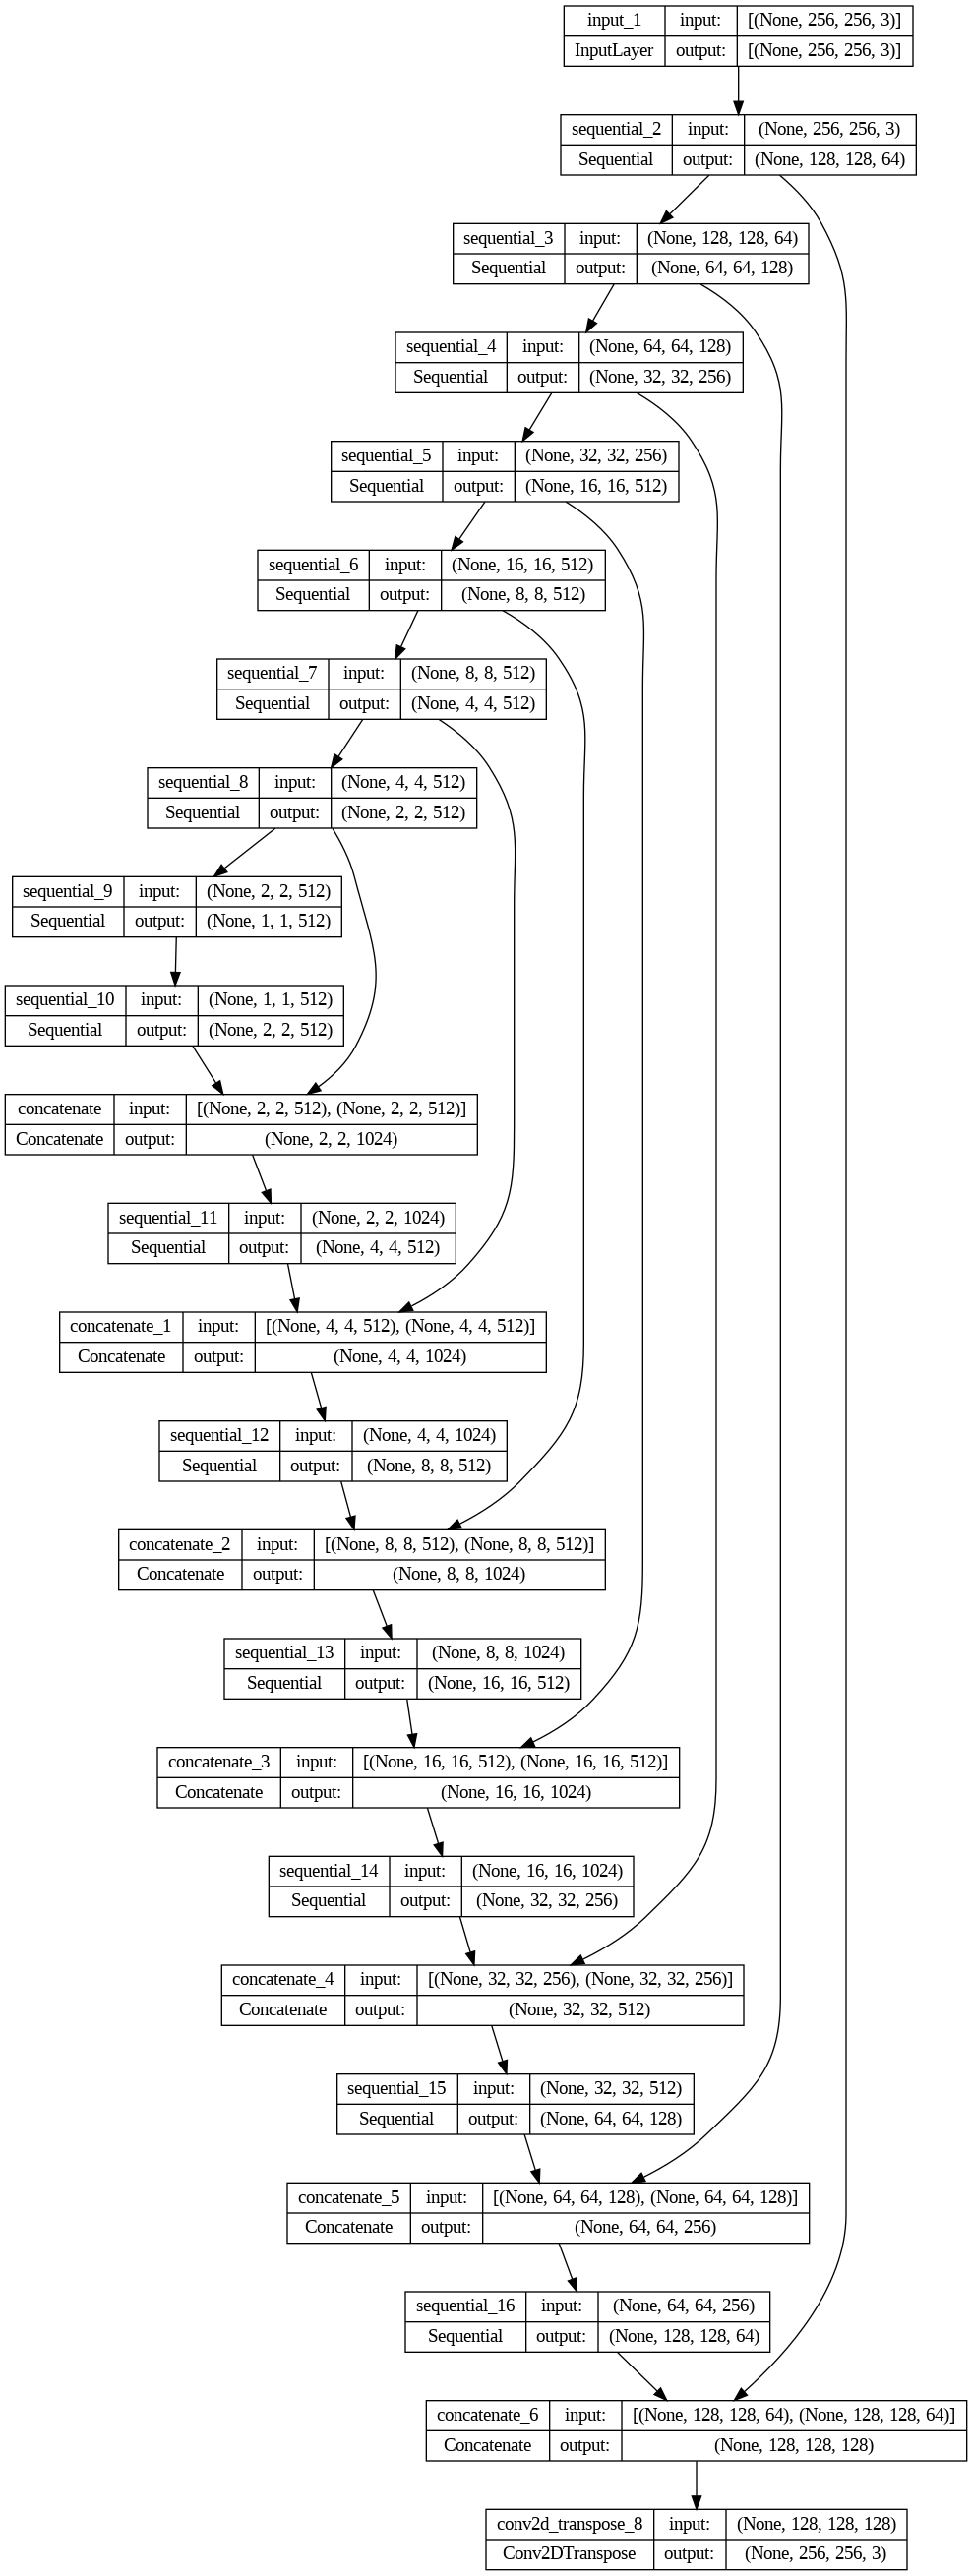

In [28]:
generator = build_generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=96)

(-0.5, 255.5, 255.5, -0.5)

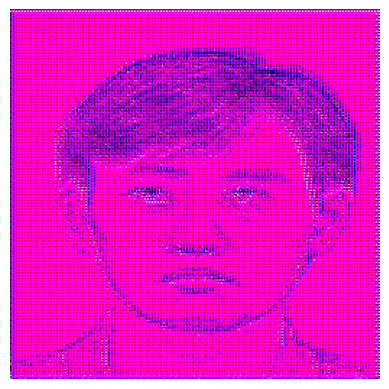

In [29]:
augmented_input_sketch, _ = random_jitter(augmented_sketches[0], augmented_sketches[1])
generator_output = generator(augmented_input_sketch[tf.newaxis, ...], training=False)
pyplot.imshow(generator_output[0, ...])
pyplot.axis('off')

In [30]:
LAMBDA = 100

In [31]:
def generator_loss(discriminator_generated_output, generator_output, target):
  gan_loss = loss_objective(tf.ones_like(discriminator_generated_output), discriminator_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - generator_output))

  total_generator_loss = gan_loss + (LAMBDA * l1_loss)
  return total_generator_loss, gan_loss, l1_loss

# Discriminator

In [32]:
def build_discriminator():
  initialiser = tf.random_normal_initializer(0., 0.02)

  input_images = tf.keras.layers.Input(shape=[256, 256, 3], name='input_images')
  target_images = tf.keras.layers.Input(shape=[256, 256, 3], name='target_images')

  inputs = tf.keras.layers.concatenate([input_images, target_images])

  downsampling_alpha = downsample(64, 4, apply_batchnorm=False)(inputs)
  downsampling_bravo = downsample(128, 4)(downsampling_alpha)
  downsampling_charlie = downsample(256, 4)(downsampling_bravo)

  zero_padding_alpha = tf.keras.layers.ZeroPadding2D()(downsampling_charlie)
  convolution = tf.keras.layers.Conv2D(
      512, 4, strides=1,
      kernel_initializer=initialiser,
      use_bias=False
  )(zero_padding_alpha)
  batch_normalisation_alpha = tf.keras.layers.BatchNormalization()(convolution)
  leaky_rlu = tf.keras.layers.LeakyReLU()(batch_normalisation_alpha)
  zero_padding_bravo = tf.keras.layers.ZeroPadding2D()(leaky_rlu)
  output_layer = tf.keras.layers.Conv2D(
    1, 4, strides=1,
    kernel_initializer=initialiser
  )(zero_padding_bravo)

  return tf.keras.Model(inputs=[input_images, target_images], outputs=output_layer)

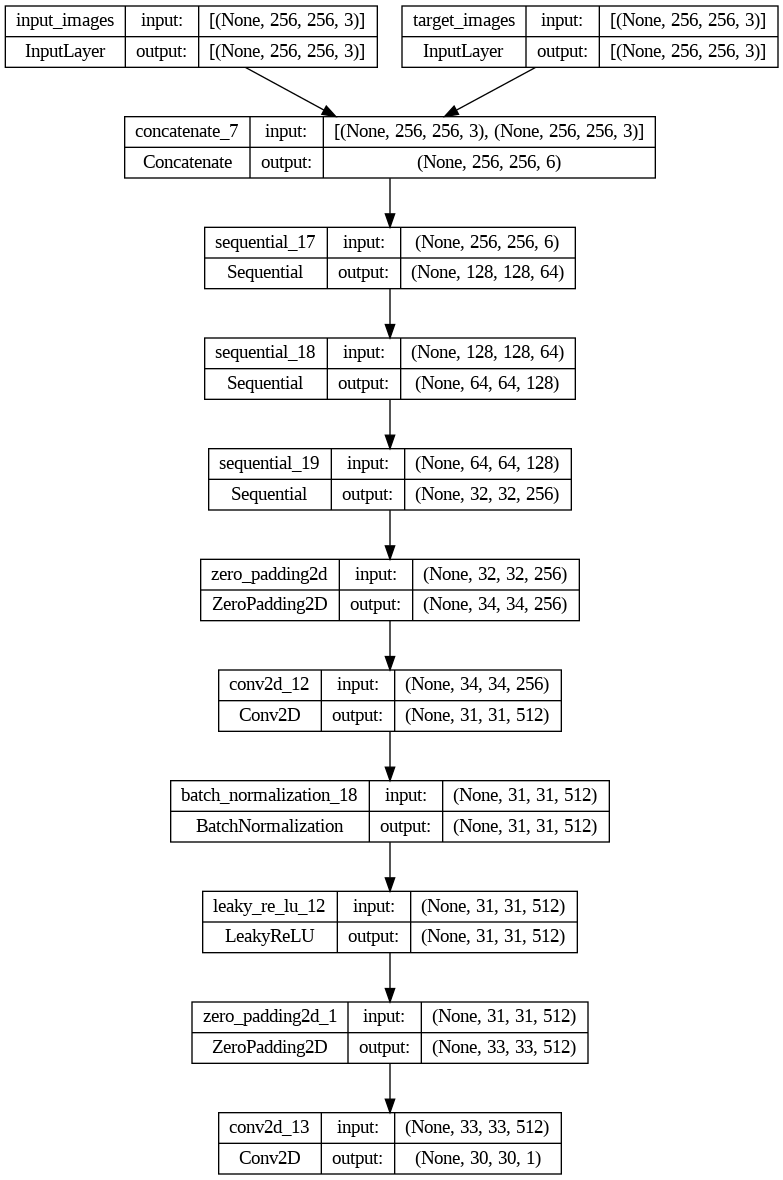

In [33]:
discriminator = build_discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=96)

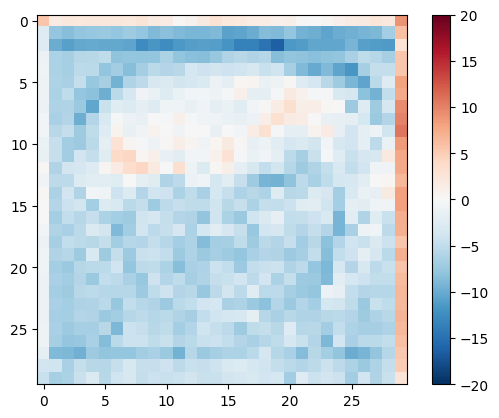

In [34]:
discriminator_output = discriminator([augmented_input_sketch[tf.newaxis, ...], generator_output], training=False)
pyplot.imshow(discriminator_output[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
pyplot.colorbar()

In [35]:
loss_objective = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [36]:
def discriminator_loss(discriminator_real_output, discriminator_generated_output):
  real_loss = loss_objective(tf.ones_like(discriminator_real_output), discriminator_real_output)
  generated_loss = loss_objective(tf.zeros_like(discriminator_generated_output), discriminator_generated_output)

  total_discriminator_loss = real_loss + generated_loss
  return total_discriminator_loss

# Optimisers and Checkpoint-saver

In [37]:
generator_optimiser = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimiser = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [38]:
!pwd

/content


In [39]:
checkpoint_directory = '../gdrive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
checkpoint = tf.train.Checkpoint(
  generator_optimizer=generator_optimiser,
  discriminator_optimizer=discriminator_optimiser,
  generator=generator,
  discriminator=discriminator
)

# Generate Images

In [40]:
def generate_images(model, testing_input, target, training=True):
  prediction = model(testing_input, training=training)
  pyplot.figure(figsize=(15, 15))

  display_list = [testing_input[0], target[0], prediction[0]]
  titles = ['Sketch', 'Ground Truth', 'Predicted Image']

  for index in range(3):
    pyplot.subplot(1, 3, index + 1)
    pyplot.title(titles[index])
    # getting the pixel values between [0, 1] to plot it
    pyplot.imshow(display_list[index] * 0.5 + 0.5)
    pyplot.axis('off')
  pyplot.show()

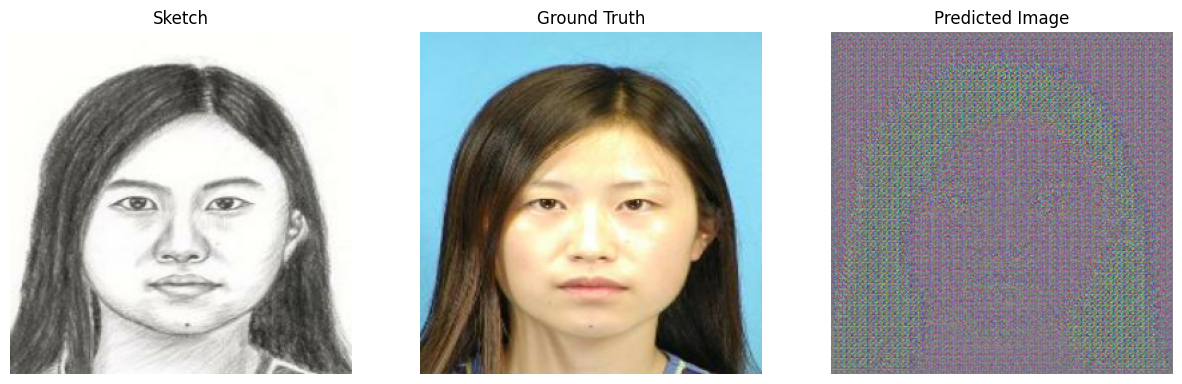

In [41]:
for example_sketch, example_target in testing_dataset.take(1):
  generate_images(generator, example_sketch, example_target)

# Training

In [42]:
EPOCHS = 100

In [43]:
from datetime import datetime
log_directory = './logs/'

training_writer = tf.summary.create_file_writer(
  log_directory + 'training/' + datetime.now().strftime("%Y%m%d-%H%M%S")
)
validation_writer = tf.summary.create_file_writer(
  log_directory + 'validation/' + datetime.now().strftime("%Y%m%d-%H%M%S")
)

In [44]:
@tf.function
def training_step(sketch, target, epoch):
  with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
    generator_output = generator(sketch, training=True)

    discriminator_real_output = discriminator([sketch, target], training=True)
    discriminator_generated_output = discriminator([sketch, generator_output], training=True)

    generator_total_loss, generator_gan_loss, generator_l1_loss = generator_loss(discriminator_generated_output, generator_output, target)
    discriminator_total_loss = discriminator_loss(discriminator_real_output, discriminator_generated_output)

  generator_gradients = generator_tape.gradient(generator_total_loss, generator.trainable_variables)
  discriminator_gradients = discriminator_tape.gradient(discriminator_total_loss, discriminator.trainable_variables)

  generator_optimiser.apply_gradients(zip(
    generator_gradients, generator.trainable_variables
  ))
  discriminator_optimiser.apply_gradients(zip(
    discriminator_gradients, discriminator.trainable_variables
  ))

  with training_writer.as_default():
    tf.summary.scalar('generator_total_loss', generator_total_loss, step=epoch)
    tf.summary.scalar('generator_gan_loss', generator_gan_loss, step=epoch)
    tf.summary.scalar('generator_l1_loss', generator_l1_loss, step=epoch)
    tf.summary.scalar('discriminator_loss', discriminator_total_loss, step=epoch)

In [45]:
def validation_step(sketch, target, epoch):
  generator_output = generator(sketch, training=False)

  discriminator_real_output = discriminator([sketch, target], training=False)
  discriminator_generated_output = discriminator([sketch, generator_output], training=False)

  generator_total_loss, generator_gan_loss, generator_l1_loss = generator_loss(discriminator_generated_output, generator_output, target)
  discriminator_total_loss = discriminator_loss(discriminator_real_output, discriminator_generated_output)

  with validation_writer.as_default():
    tf.summary.scalar('generator_total_loss', generator_total_loss, step=epoch)
    tf.summary.scalar('generator_gan_loss', generator_gan_loss, step=epoch)
    tf.summary.scalar('generator_l1_loss', generator_l1_loss, step=epoch)
    tf.summary.scalar('discriminator_loss', discriminator_total_loss, step=epoch)

In [46]:
CHECKPOINT_FREQUENCY = 20 # epochs

def fit(training_dataset, validation_dataset, testing_dataset, epochs):
  for epoch in range(epochs):
    start_time = time.time()
    display.clear_output(wait=True)

    for example_sketch, example_target in testing_dataset.take(1):
      generate_images(generator, example_sketch, example_target)
    print(f'\nEpoch: {epoch}')

    for (input_sketch, target) in tqdm(training_dataset, desc='Batch progress'):
      training_step(input_sketch, target, epoch)
    for (input_sketch, target) in tqdm(validation_dataset, desc='Validation progress'):
      validation_step(input_sketch, target, epoch)

    if (epoch + 1) % CHECKPOINT_FREQUENCY == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'\nTime taken for epoch {epoch + 1} is {time.time() - start_time} seconds.')

In [47]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir {log_directory}

<IPython.core.display.Javascript object>

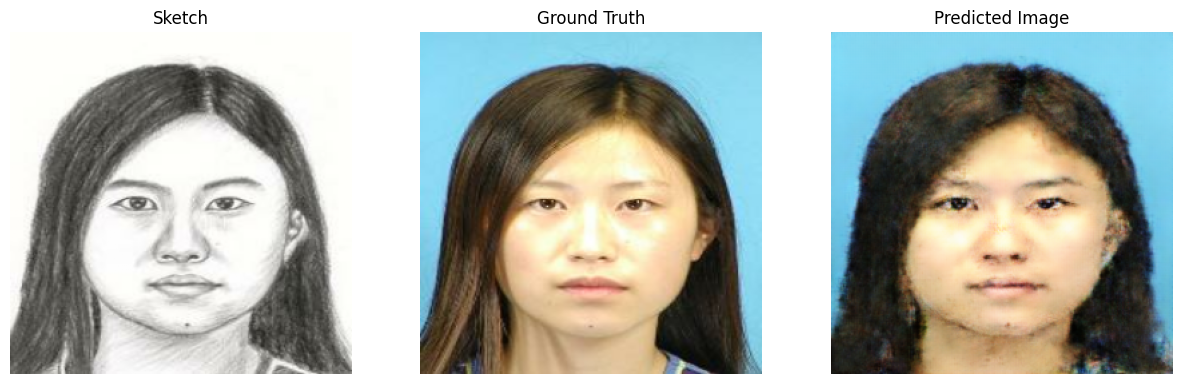


Epoch: 65


Batch progress:   7%|▋         | 49/671 [00:06<00:52, 11.76it/s]

In [ ]:
fit(partial_training_dataset, validation_dataset, testing_dataset, EPOCHS)

# Generate Images from the Testing Dataset

In [ ]:
!ls {checkpoint_directory}

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_directory))

In [ ]:
for sketch, target in testing_dataset.take(5):
  generate_images(generator, sketch, target, training=True)

In [ ]:
example_t = '/content/0001_1_1.jpg'
example_s = '/content/0001_1_1_sz1.jpg'
generate_images(generator, example_s , example_t, training=True)

In [ ]:
def resize_to_input_resolution(generator_output):
    _, generator_output = resize(generator_output, generator_output, width=image_width, height=image_height)
    return generator_output

def calculate_mean_for_dataset(resized_testing_dataset, original_testing_dataset):
    generated_images = []
    total_mean_absolute_error = 0
    processed_batches = 0
    for (sketch, _), (_, target) in tqdm(zip(resized_testing_dataset, original_testing_dataset)):
        generator_batch_output = generator(sketch, training=False)
        generator_batch_output = tf.map_fn(resize_to_input_resolution, generator_batch_output)

        mean_absolute_error = tf.reduce_mean(tf.abs(target - generator_batch_output))
        total_mean_absolute_error += mean_absolute_error
        processed_batches += 1

    return (total_mean_absolute_error, (total_mean_absolute_error / processed_batches))

In [ ]:
non_resized_testing_dataset = tf.data.Dataset.from_tensor_slices((
  testing_sketches,
  testing_photos
))
non_resized_testing_dataset = non_resized_testing_dataset.map(lambda sketch, photo: normalise(sketch, photo))

print(non_resized_testing_dataset.take(1))
for sketch, image in non_resized_testing_dataset.take(1):
    pyplot.subplot(1, 2, 1)
    pyplot.imshow(sketch * 0.5 + 0.5)
    pyplot.axis('off')
    pyplot.subplot(1, 2, 2)
    pyplot.imshow(image * 0.5 + 0.5)
    pyplot.axis('off')
    pyplot.show()

In [ ]:
total_mean_absolute_error, mean_mean_absolute_error = calculate_mean_for_dataset(testing_dataset, non_resized_testing_dataset)
print()
print(f'total mean absolute error on the testing dataset: {total_mean_absolute_error}')
print(f'mean of mean absolute error on the testing dataset: {mean_mean_absolute_error}')